# **Project Name:** 2024 Ecommerce Dataset Analysis

### **Tools** - Python, ML, SQL, Excel
### **Domain** - Data Analytics
### **No of Members** - 1
### **Member Name** - Shubhayan Baral
### **Contribution** - Individual

## **Business Problem & Objective**

### **Problem Statement**
E-commerce furniture platforms struggle to accurately predict product demand due to highly skewed sales patterns and limited product-level information. Poor demand forecasting can lead to overstocking, stockouts, and ineffective pricing strategies.

### **Objective**
The objective of this project is to:

- Predict the number of units sold for furniture products using machine learning

- Analyze the impact of price and discounts on sales

- Support data-driven inventory and pricing decisions

# ***Let's Start!***

## *Import Libraries*

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## *Import Dataset*

In [5]:
df = pd.read_csv("ecommerce_furniture_dataset_2024.csv")
df.head()

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   productTitle   2000 non-null   object
 1   originalPrice  487 non-null    object
 2   price          2000 non-null   object
 3   sold           2000 non-null   int64 
 4   tagText        1997 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


,sold
count,2000.000000
mean,23.493500
std,254.094061
min,0.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,10000.000000


In [7]:
df['price'] = (
    df['price']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
)

df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [8]:
df['originalPrice'] = (
    df['originalPrice']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
)

df['originalPrice'] = pd.to_numeric(df['originalPrice'], errors='coerce')

In [9]:
df['discount'] = df['originalPrice'] - df['price']
df['discount'] = df['discount'].fillna(0)

In [10]:
df.isna().sum()

productTitle        0
originalPrice    1513
price               0
sold                0
tagText             3
discount            0
dtype: int64

In [11]:
df['productTitle'] = df['productTitle'].fillna("")
df['tagText'] = df['tagText'].fillna("Unknown")

## ***Data Visualisation & Exploratory Data Analysis***

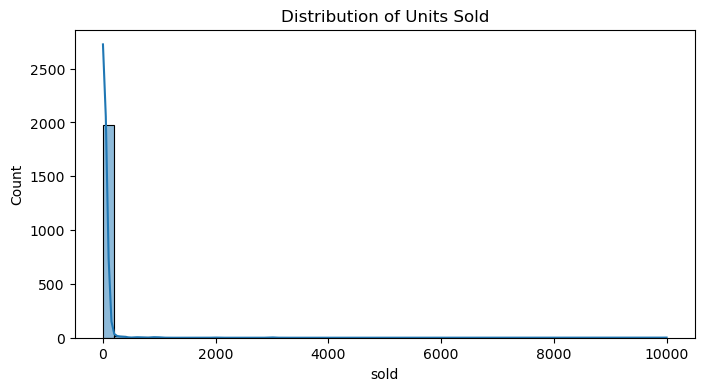

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(df['sold'], bins=50, kde=True)
plt.title("Distribution of Units Sold")
plt.show()

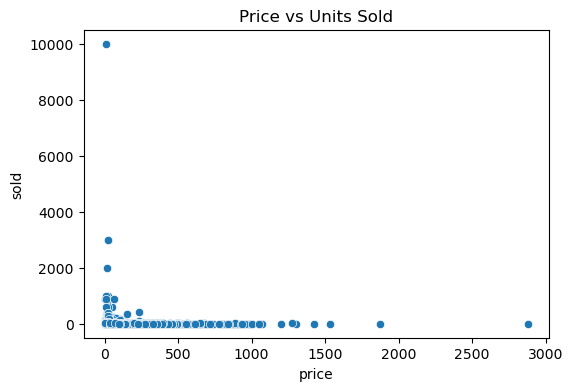

In [13]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='price', y='sold', data=df)
plt.title("Price vs Units Sold")
plt.show()

## **Model Implementation & Training**

In [14]:
X = df[['productTitle', 'price', 'discount']]
y = np.log1p(df['sold'])  # 🔥 LOG TRANSFORMATION

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            stop_words='english',
            max_features=300
        ), 'productTitle'),
        
        ('num', 'passthrough', ['price', 'discount'])
    ]
)

In [17]:
lr_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])

lr_model.fit(X_train, y_train)

y_pred_lr_log = lr_model.predict(X_test)

# Convert back from log scale
y_pred_lr = np.expm1(y_pred_lr_log)
y_test_actual = np.expm1(y_test)

print("Linear Regression")
print("MAE:", mean_absolute_error(y_test_actual, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred_lr)))
print("R2 Score:", r2_score(y_test_actual, y_pred_lr))

Linear Regression
MAE: 17.564792566053892
RMSE: 72.20190146219596
R2 Score: 0.049312202889449264


In [18]:
rf_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf_log = rf_model.predict(X_test)

# Convert back from log scale
y_pred_rf = np.expm1(y_pred_rf_log)

print("\nRandom Forest Regressor")
print("MAE:", mean_absolute_error(y_test_actual, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred_rf)))
print("R2 Score:", r2_score(y_test_actual, y_pred_rf))



Random Forest Regressor
MAE: 16.473278203150045
RMSE: 67.86722290238536
R2 Score: 0.16003574247099972


In [19]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R2 Score": [
        r2_score(y_test_actual, y_pred_lr),
        r2_score(y_test_actual, y_pred_rf)
    ]
})

results


,Model,R2 Score
0,Linear Regression,0.049312
1,Random Forest,0.160036


In [20]:
def predict_sales(model, product_title, price, original_price=None):
    """
    Predict units sold for a new product using trained model
    """
    
    # Calculate discount safely
    if original_price is None:
        discount = 0
    else:
        discount = max(original_price - price, 0)
    
    # Create input DataFrame
    input_data = pd.DataFrame({
        'productTitle': [product_title],
        'price': [price],
        'discount': [discount]
    })
    
    # Predict (log scale)
    pred_log = model.predict(input_data)
    
    # Convert back to original scale
    pred_sales = np.expm1(pred_log)
    
    return int(round(pred_sales[0]))


## *Predicting Sales using ML*

In [21]:
predict_sales(
    model=rf_model,
    product_title="Modern Wooden Study Table with Storage",
    price=120,
    original_price=150
)


4